# London Housing - Exploratory Data Analysis

Using the following dataset from Kaggle: [Kaggle](https://www.kaggle.com/datasets/oktayrdeki/houses-in-london)
- "10m_london_houses.csv" | 130 kB

This notebook will investigate the data and aim to answer the following questions.

1. What predicts price most strongly? (Likely: Square Meters, Neighborhood, Property Type)
2. What's the data quality? (Missing values, outliers, errors)
3. What transformations are needed? (Log price? Scale features? Encode categories?)
4. Are there data segments? (Luxury vs standard, urban vs suburban)
5. What features to engineer? (Price per sqm, age categories, luxury indicators)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print(np.__version__)

1.24.3


In [2]:
data_path = 'data/10m_london_houses_.csv'
housing_df = pd.read_csv(data_path)

housing_df.head()

,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## 1. Price

Plot price distribution

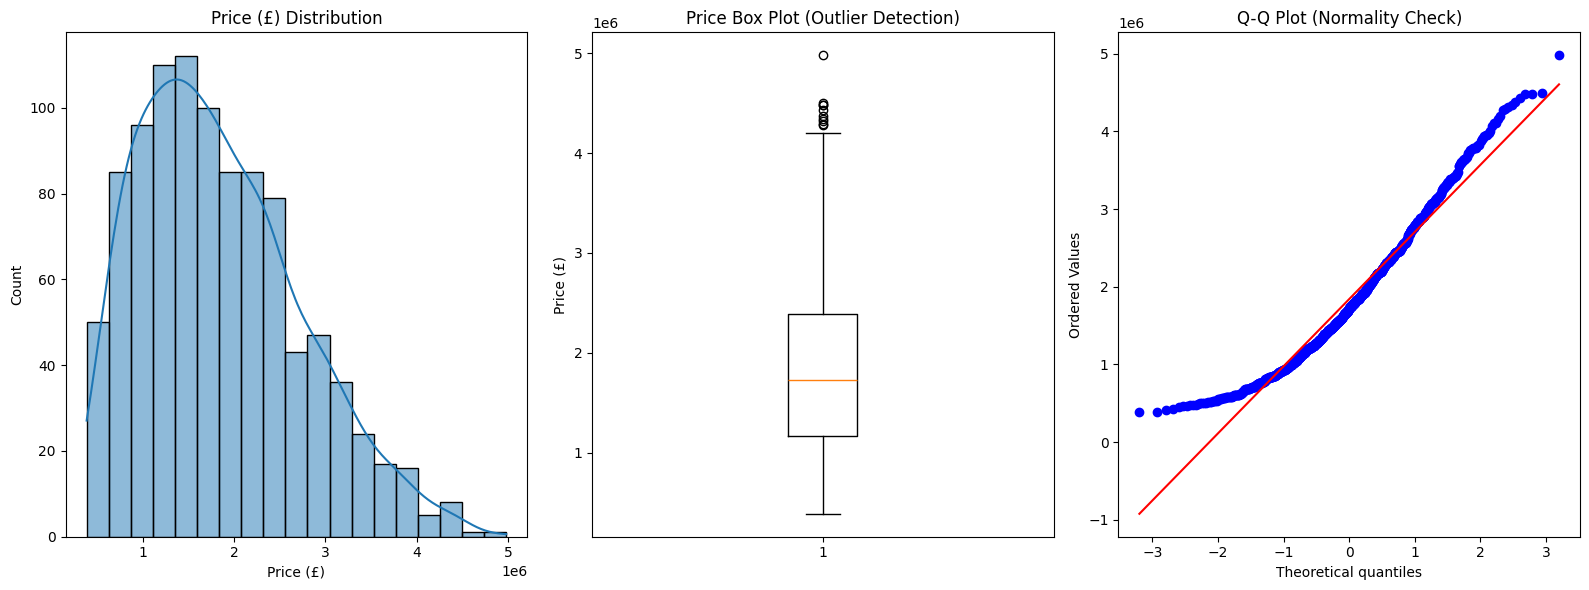

In [25]:
fig = plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 3, 1)
sns.histplot(housing_df["Price (£)"], kde=True)
ax1.set_title("Price (£) Distribution")
ax1.set_xlabel("Price (£)")

# Box plot
ax2 = plt.subplot(1, 3, 2)
ax2.boxplot(housing_df['Price (£)'])
ax2.set_ylabel('Price (£)')
ax2.set_title('Price Box Plot (Outlier Detection)')

# Q-Q plot
ax3 = plt.subplot(1, 3, 3)
stats.probplot(housing_df['Price (£)'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
# plt.savefig(plotDir + 'price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Detect outliers using IQR method
Q1 = housing_df['Price (£)'].quantile(0.25)
Q3 = housing_df['Price (£)'].quantile(0.75)
IQR = Q3 - Q1
outliers = housing_df[(housing_df['Price (£)'] < Q1 - 1.5 * IQR) | (housing_df['Price (£)'] > Q3 + 1.5 * IQR)]

Plot price per square meter distribution

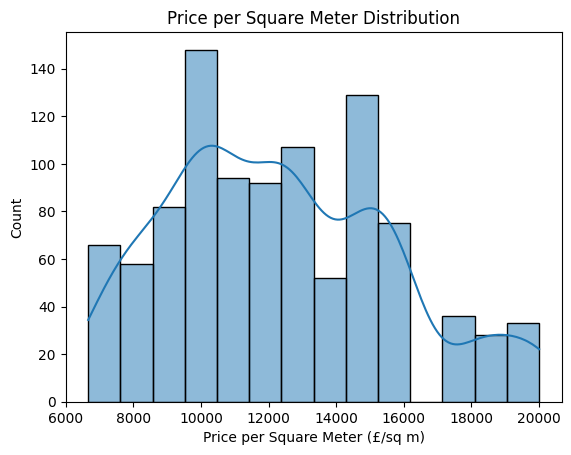

In [6]:
# Create price per square foot column
housing_df['Price per sq m'] = housing_df['Price (£)'] / housing_df['Square Meters']
# Price per square foot distribution
plt.figure()
sns.histplot(housing_df["Price per sq m"], kde=True)
plt.title("Price per Square Meter Distribution")
plt.xlabel("Price per Square Meter (£/sq m)")
plt.show()

## 2. Numeric Data

Extract numerica columns.

In [7]:
numeric_cols = ["Price (£)", "Square Meters", "Bedrooms", "Bathrooms", "Building Age"]

Correlation matrix.

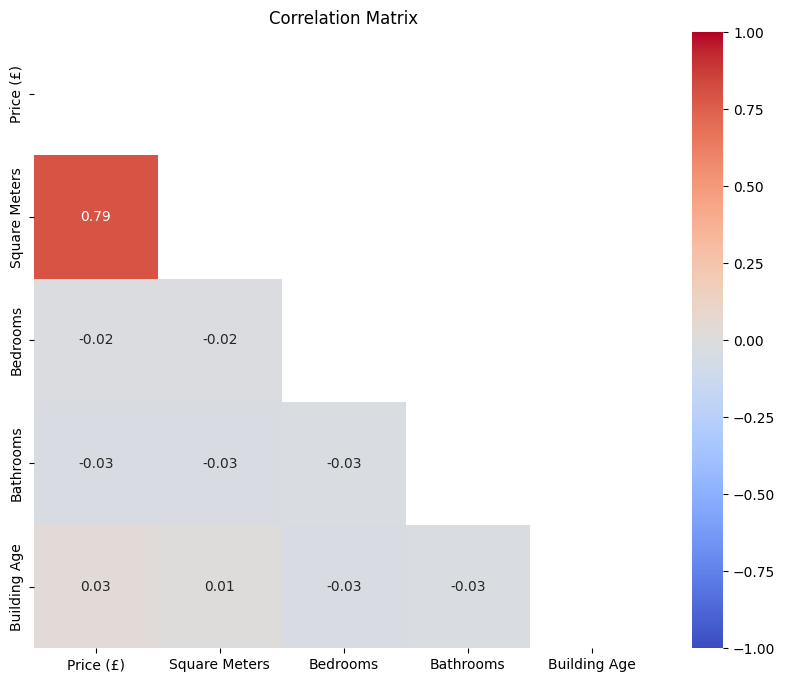

In [8]:
corr_mask = np.triu(np.ones_like(housing_df[numeric_cols].corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(housing_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", mask=corr_mask, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Pairwise plot

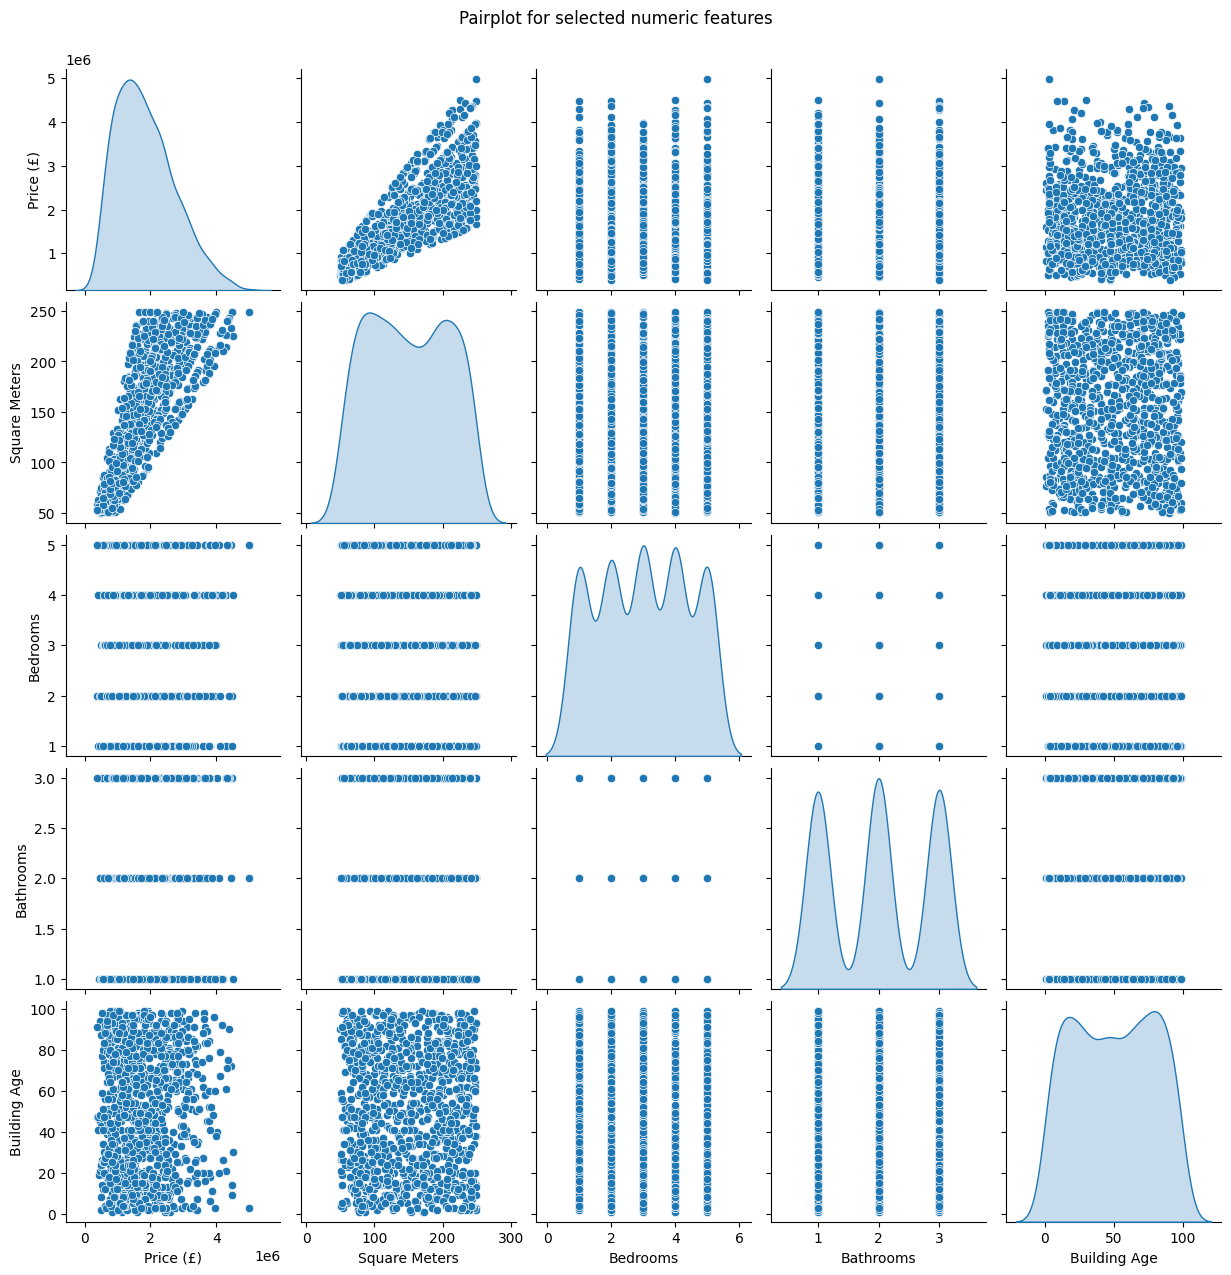

In [6]:
# Pairwise scatter for a few key numeric features (pairplot)
sns.pairplot(housing_df[numeric_cols], diag_kind="kde")
plt.suptitle("Pairplot for selected numeric features", y=1.02)
plt.show()

## 3. Categoric Data

Extract categoric columns.

In [46]:
categorical_cols = housing_df.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical features: {categorical_cols}")

# Cardinality check
print("\n--- Cardinality (Number of Unique Values) ---")
for col in categorical_cols:
    unique_count = housing_df[col].nunique()
    print(f"{col}: {unique_count} unique values")


Categorical features: ['Address', 'Neighborhood', 'Garden', 'Garage', 'Property Type', 'Heating Type', 'Balcony', 'Interior Style', 'View', 'Materials', 'Building Status']

--- Cardinality (Number of Unique Values) ---
Address: 770 unique values
Neighborhood: 10 unique values
Garden: 2 unique values
Garage: 2 unique values
Property Type: 3 unique values
Heating Type: 4 unique values
Balcony: 3 unique values
Interior Style: 4 unique values
View: 5 unique values
Materials: 4 unique values
Building Status: 3 unique values


Square meters vs price, colored by neighborhood

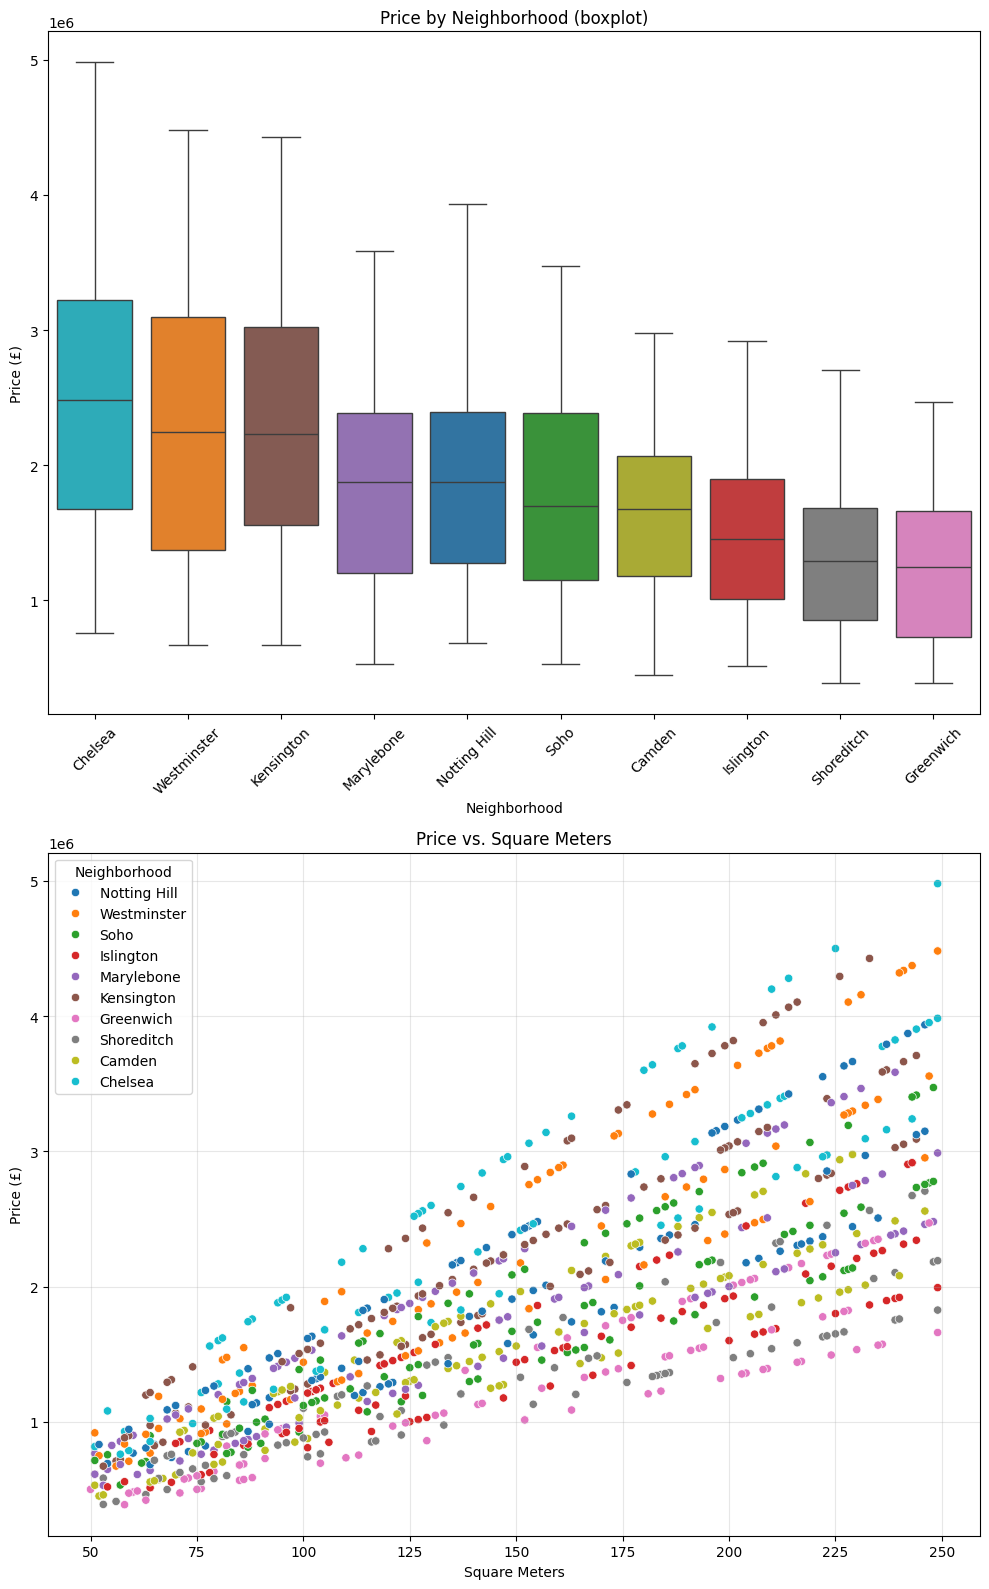

In [59]:
# Boxplot: Price by Neighborhood
neighborhood_fig, axes_n = plt.subplots(2, 1, figsize=(10, 16))

order = housing_df.groupby("Neighborhood")["Price (£)"].median().sort_values(ascending=False).index
sns.boxplot(data=housing_df, x="Neighborhood", y="Price (£)", order=order, hue="Neighborhood", ax=axes_n[0])
axes_n[0].tick_params(axis='x', rotation=45)
axes_n[0].set_title("Price by Neighborhood (boxplot)")

sns.scatterplot(data=housing_df, x='Square Meters', y='Price (£)', hue='Neighborhood', ax=axes_n[1])
axes_n[1].grid(True, alpha=0.3)
axes_n[1].set_title("Price vs. Square Meters")

plt.tight_layout()
plt.show()

Create violin plots for the following columns: Property Type, Heating Type, Interior Style, View, Materials and Building Status

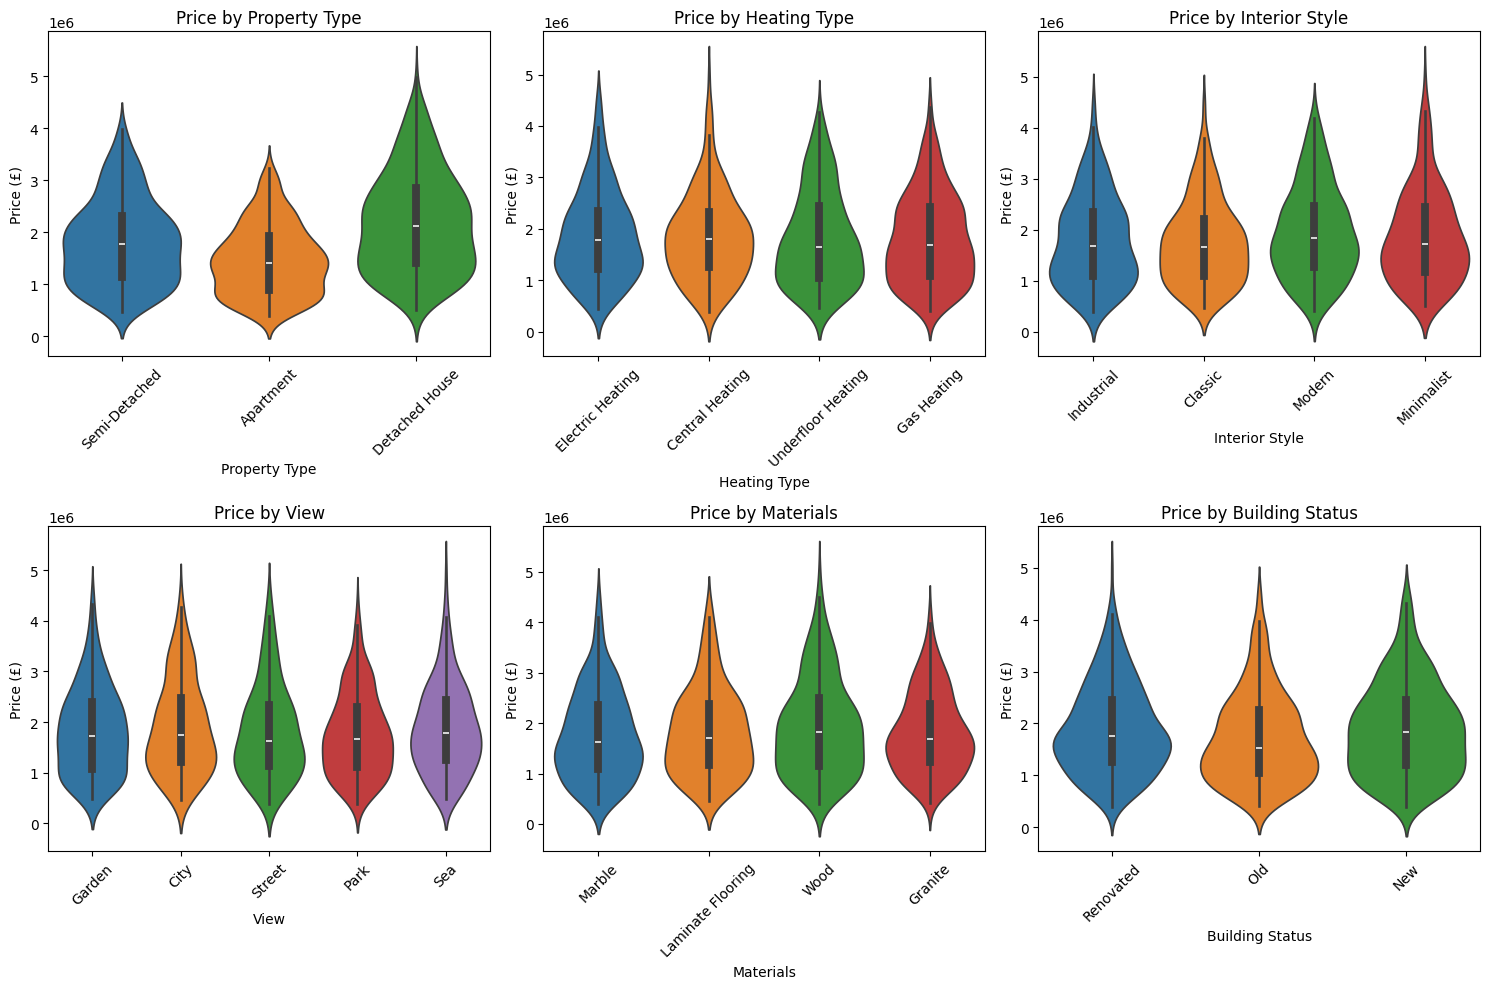

In [50]:
# Create subplots
violin_fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Loop through columns and create violin plots
for i, col in enumerate(['Property Type', 'Heating Type', 'Interior Style', 'View', 'Materials', 'Building Status']):
    sns.violinplot(data=housing_df, x=col, y='Price (£)', hue=col, ax=axes[i])
    axes[i].set_title(f'Price by {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Look at street addresses

Neighborhood data - why all straight lines?